In [10]:
#The goal of this notebook is to obtain statistics about the distribution of weights in the ER Layered Digraph

import networkx as nx
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

In [361]:
def viz(graph):
    pos = {x : graph.nodes[x]["pos"] for x in graph.nodes()}
    col = [graph.nodes[x]["weight"] for x in graph.nodes()]
    nx.draw(graph, pos, node_color =col, node_labels = col, node_size = 100, width =.5)


def erdos_renyi(n = 4, d = 3, p=.5):
    #Assign Weights Across Each layer as 1...n
    layered_nodes = itertools.product(range(n), range(d))
    graph = nx.DiGraph()
    graph.add_nodes_from(layered_nodes)
    
    for x in graph.nodes():
        #print(x)
        graph.nodes[x]["pos"] = np.array([x[0], x[1]])
        
    graph.graph["num_layers"] = d
    graph.graph["width"] = n
    
    for i in range(n):
        for j in range(n):
            for k in range(d-1):
                if random.uniform(0,1) < p:
                    graph.add_edge( (i,k), (j, k+1))
    
    i = 0
    graph.graph["names"] = {}
    for x in graph.nodes():
        #print(x)
        graph.nodes[x]["pos"] = np.array([x[0], x[1]])
        graph.nodes[x]["label"] = i
        graph.graph["names"][i] = x
        i += 1
        graph.nodes[x]["weight"] = x[0] % n
    #graph.graph["s"] = (0,0)
    #graph.graph["t"] = (0,d)
    #viz(graph)          
    return graph


def node_weights_to_edge_weights(graph):
    #Updates the edge weights based on node weights.
    #Profiler says this is the bottleneck. That makes no sense...
    for e in graph.edges():
        graph.edges[e]["weight"] = graph.nodes[e[0]]["weight"] + graph.nodes[e[1]]["weight"]     
    return graph


def initialize_distributions(max_weight, len_zero_wt, len_zero_count):
    distribution = {}
    for i in range(max_weight):
        distribution[i] = 0
    distribution[len_zero_wt] = len_zero_count    
    return distribution

def update_distribution(distributions, current_node, parent_node, weight_from_current_node):
    parent_distribution = distributions[parent_node]
    new_paths = {}
    for x in parent_distribution.keys():
        #each path of weight w to parent node gives a path of weight w + weight_from_current_node to current_node
        if parent_distribution[x] != 0:
            (distributions[current_node])[x + weight_from_current_node] += parent_distribution[x]
    return distributions


def weight_distribution(LDG):
    '''
    A dynamic program to get the distribution of weights of all paths from the top to bottom layer of the LDG
    '''
    d = LDG.graph["num_layers"]
    n = LDG.graph["width"]
    max_weight = d*n
    distributions = {}
    
    for x in LDG.nodes():
        distributions[x] = initialize_distributions(max_weight, 0,0)
    #print(distributions[x])
    for i in range(n):
        #LDG.nodes[LDG.graph["names"][i]]["counts"] = {}
        distributions[ (i,0) ] = initialize_distributions(max_weight, i,1)
        
    for k in range(1, d):
        for j in range(n):
            #Working with node (j,k)
            for i in range(n):
                #find list of parent nodes
                if ((i, k -1), (j,k)) in LDG.edges():
                    weight_from_current_node = LDG.nodes[ (j,k)]["weight"]
                    distributions = update_distribution(distributions, (j,k), (i,k-1), weight_from_current_node)
                    
    return distributions

def sum_histograms(list_of_histograms):
    #We'll assume the histograms have the same keys
    total = {}
    for x in list_of_histograms[0].keys():
        total[x] = 0
        for hist in list_of_histograms:
            total[x] += hist[x]
    return total

def has_path(LDG):
    for i in range(n):
        for j in range(n):
            s = (i,0)
            t = (j, d-1)
            if nx.has_path(LDG, s,t):
                return True
    return False

def analyze_distributions(LDG):
    d = LDG.graph["num_layers"]
    n = LDG.graph["width"]
    distributions = weight_distribution(LDG)
    for k in range(d):
        list_of_histograms = []
        for i in range(n):
            list_of_histograms.append(distributions[(i , k)])
        total = sum_histograms(list_of_histograms)
        plt.bar(list(total.keys()), total.values(), color='g')
        plt.show()
        nonzerokeys = []
        for x in total.keys():
            if total[x] != 0:
                nonzerokeys.append(x)
        min_weight = np.min(nonzerokeys)
    print(min_weight, total[min_weight])
    return distributions

In [ ]:

for n in [50]:
    for d in [50]:
        successes = 0
        for trials in range(100):
            p = .5
            LDG = erdos_renyi(n,d,p)
            LDG = node_weights_to_edge_weights(LDG)
            distributions = weight_distribution(LDG)
            list_of_histograms = []
            for i in range(n):
                list_of_histograms.append(distributions[(i , d-1)])
            total = sum_histograms(list_of_histograms)
            plt.bar(list(total.keys()), total.values(), color='g')
            plt.show()
            nonzerokeys = []
            for x in total.keys():
                if total[x] != 0:
                    nonzerokeys.append(x)
            min_weight = np.min(nonzerokeys)
            #print(min_weight, total[min_weight])
            if total[min_weight] == 1:
                successes += 1
        print(n,d,successes)
        
        


In [373]:
for n in range(3,20):
    for i in range(10000):
        worst_count = 1
        #n = 3
        d = n
        level = 0
        #Note that d <= n is necessary. 
        p = .6
        LDG = erdos_renyi(n,d,p)
        while not has_path(LDG):
            LDG = erdos_renyi(n,d,p)
        LDG = node_weights_to_edge_weights(LDG)
        distributions = weight_distribution(LDG)
        for k in range(d):
            list_of_histograms = []
            for i in range(n):
                list_of_histograms.append(distributions[(i , k)])
            total = sum_histograms(list_of_histograms)
            #plt.bar(list(total.keys()), total.values(), color='g')
            #plt.show()
            nonzerokeys = []
            for x in total.keys():
                if total[x] != 0:
                    nonzerokeys.append(x)
            min_weight = np.min(nonzerokeys)
        
            if total[min_weight] > worst:
                level = k
                worst_count = total[min_weight]
                worst_weight = min_weight
        if total[min_weight] >= 2*(n**2):
            #We get an exponentially growing example?
            #Well, no... we can't just keep doubling d. 
            
            found_graph = LDG
            viz(LDG)
    
    print("n:", n, "d:", level, worst_weight, worst_count)

n: 3 d: 1 1 2
n: 4 d: 2 2 2
n: 5 d: 0 2 1
n: 6 d: 1 1 2
n: 7 d: 6 4 6
n: 8 d: 5 3 4
n: 9 d: 7 5 6
n: 10 d: 0 1 1
n: 11 d: 5 5 5
n: 12 d: 0 3 1
n: 13 d: 0 3 1
n: 14 d: 0 6 1
n: 15 d: 2 1 2
n: 16 d: 6 3 3
n: 17 d: 2 2 2
n: 18 d: 4 2 2
n: 19 d: 12 4 4


In [374]:
for n in range(3,20):
    for i in range(10000):
        worst_count = 1
        #n = 3
        d = n
        level = 0
        #Note that d <= n is necessary. 
        p = .5
        LDG = erdos_renyi(n,d,p)
        while not has_path(LDG):
            LDG = erdos_renyi(n,d,p)
        LDG = node_weights_to_edge_weights(LDG)
        distributions = weight_distribution(LDG)
        for k in range(d):
            list_of_histograms = []
            for i in range(n):
                list_of_histograms.append(distributions[(i , k)])
            total = sum_histograms(list_of_histograms)
            #plt.bar(list(total.keys()), total.values(), color='g')
            #plt.show()
            nonzerokeys = []
            for x in total.keys():
                if total[x] != 0:
                    nonzerokeys.append(x)
            min_weight = np.min(nonzerokeys)
        
            if total[min_weight] > worst:
                level = k
                worst_count = total[min_weight]
                worst_weight = min_weight
        if total[min_weight] >= 2*(n**2):
            #We get an exponentially growing example?
            #Well, no... we can't just keep doubling d. 
            
            found_graph = LDG
            viz(LDG)
    
    print("n:", n, "d:", level, worst_weight, worst_count)

n: 3 d: 0 4 1
n: 4 d: 0 3 1
n: 5 d: 0 4 1
n: 6 d: 0 7 1
n: 7 d: 0 4 1
n: 8 d: 0 5 1
n: 9 d: 0 6 1
n: 10 d: 0 7 1
n: 11 d: 0 10 1
n: 12 d: 0 11 1
n: 13 d: 0 6 1
n: 14 d: 8 8 5
n: 15 d: 0 14 1
n: 16 d: 0 10 1
n: 17 d: 0 18 1
n: 18 d: 0 11 1
n: 19 d: 0 16 1


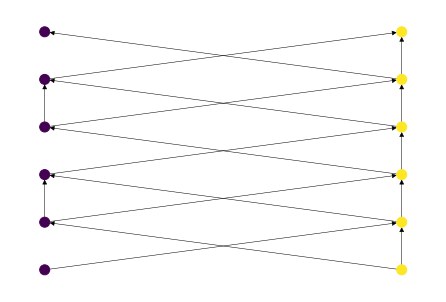

In [359]:
viz(found_graph)

In [358]:
len(LDG)

2500